### Deriving Greeks from option spreads
Imports data from `adjusted_options` although raw data works fine as well

In [1]:
import datetime
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import multiprocessing
from multiprocessing.pool import Pool
from pathlib import Path

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [2]:
stock_of_interest = "AAPL"
option_data_path = "data/adjusted_options/"
default_save_path = "data/greeks/"

**Load adjusted options data**

In [3]:
try:
    options_df = pd.read_csv(os.path.abspath(os.path.join(option_data_path, (stock_of_interest + ".csv"))))
    options_df["date"] = pd.to_datetime(options_df["date"]).dt.date
    options_df["expiration date"] = pd.to_datetime(options_df["expiration date"]).dt.date
except FileNotFoundError:
    raise SystemExit("Option data for " + stock_of_interest + " not found in path: " +
                     os.path.abspath(os.path.join(option_data_path, stock_of_interest)) + ".csv")

In [4]:
call_options = options_df[options_df["type"] == "call"]


Delta ($\Delta$) at a certain strike price (K) is calculated based off the forward and backward change in strike price. For example, for K=20, the delta at K=19.5 is calculated by taking the slope between K=19 and K=20. Likewise, Delta at K=20.5 is based off ask/bid prices at K=20 and K=21.

Note that the assumption of midpoint is built upon the existence of a monotonic Delta function, which is realistic. For example, the Delta of long calls should decrease from 1 (very ITM) to 0 (very OTM).

The same logic is applied for calculating Gamma ($\Gamma$).

Since calculated Delta and Gamma values are midpoints between their respective strike prices, the greek values for the original option strikes are **linearly** interpolated.

A function of Delta and Gamma at different strike prices is dependent on the price of the underlying, and shifts horizontally accordingly. Using the amount by which the option is ITM or OTM (dividend adjusted), we create a new feature measuring the difference between closing price and strike price (`adj_close - adj_strike`).
    - POSITIVE -> ITM
    - NEGATIVE -> OTM

In [5]:
def calc_delta_gamma(input_df):
    # Calculating Delta
    temp_delta_df = input_df[["strike price", "ask price", "bid price"]].diff()[1:].reset_index(drop=True)
    temp_delta_df = temp_delta_df.rename(columns={"strike price": "asset change",
                                                  "ask price": "ask change",
                                                  "bid price": "bid change"})
    # Change in asset price is negative of change in  strike price
    temp_delta_df["asset change"] = -temp_delta_df["asset change"]
    # Strike price for delta to be midpoint between the two options
    temp_delta_df["strike price"] = (input_df["strike price"][:-1].reset_index(drop=True) +
                                     input_df["strike price"][1:].reset_index(drop=True)) / 2
    temp_delta_df["ask"] = temp_delta_df["ask change"] / (temp_delta_df["asset change"])
    temp_delta_df["bid"] = temp_delta_df["bid change"] / (temp_delta_df["asset change"])
    # Add type
    temp_delta_df["type"] = "slope midpoint"

    # Calculating Gamma
    temp_gamma_df = temp_delta_df[["strike price", "ask", "bid"]].diff()[1:].reset_index(
        drop=True)
    temp_gamma_df = temp_gamma_df.rename(columns={"strike price": "asset change",
                                                  "ask": "ask change",
                                                  "bid": "bid change"})
    temp_gamma_df["asset change"] = -temp_gamma_df["asset change"]
    temp_gamma_df["strike price"] = (temp_delta_df["strike price"][:-1].reset_index(drop=True) +
                                     temp_delta_df["strike price"][1:].reset_index(drop=True)) / 2
    temp_gamma_df["ask"] = temp_gamma_df["ask change"] / temp_gamma_df["asset change"]
    temp_gamma_df["bid"] = temp_gamma_df["bid change"] / temp_gamma_df["asset change"]
    # Add type
    temp_gamma_df["type"] = "slope midpoint"

    # Add on strike prices of actual options
    temp_delta_df = temp_delta_df.merge(input_df[["strike price"]],
                                        how="outer",
                                        on=["strike price"])
    temp_gamma_df = temp_gamma_df.merge(input_df[["strike price"]],
                                        how="outer",
                                        on=["strike price"])

    # Sort order of rows, ignore_index re-indexes for loop below
    temp_delta_df.sort_values(by=["strike price"],
                              inplace=True, ignore_index=True)
    temp_gamma_df.sort_values(by=["strike price"],
                              inplace=True, ignore_index=True)

    for temp_df in [temp_delta_df, temp_gamma_df]:
        # Estimate missing delta/gamma of actual options
        # Special cases
        if np.isnan(temp_df.loc[0, "ask"]):
            # Find FIRST entry available
            temp_df.loc[0, "type"] = "interpolation"
            completed_temp_df = temp_df[-np.isnan(temp_df["ask"])].reset_index(drop=True)
            temp_df.loc[0, ["ask", "bid"]] = completed_temp_df.loc[0, ["ask", "bid"]]
        if np.isnan(temp_df.loc[temp_df.shape[0] - 1, "ask"]):
            # Find LAST entry available
            temp_df.loc[temp_df.shape[0] - 1, "type"] = "interpolation"
            completed_temp_df = temp_df[-np.isnan(temp_df["ask"])].reset_index(drop=True)
            temp_df.loc[temp_df.shape[0] - 1, ["ask", "bid"]] = completed_temp_df.loc[
                completed_temp_df.index[-1], ["ask", "bid"]]
        # Everything in the middle
        for n in range(temp_df.shape[0]):
            if not np.isnan(temp_df.loc[n, "ask"]):
                continue
            else:
                temp_df.loc[n, "type"] = "interpolation"
                # Find the next entry that is not NaN
                forward_shift = 1
                while np.isnan(temp_df.loc[n + forward_shift, "ask"]):
                    forward_shift += 1
                prev_distance = float(temp_df.loc[n, "strike price"] -
                                      temp_df.loc[n - 1, "strike price"])
                next_distance = float(temp_df.loc[n + forward_shift, "strike price"] -
                                      temp_df.loc[n, "strike price"])
                temp_df.loc[n, ["ask", "bid"]] = (((next_distance / (prev_distance + next_distance)) *
                                                   temp_df.loc[n - 1, ["ask", "bid"]]) +
                                                  ((prev_distance / (prev_distance + next_distance)) *
                                                   temp_df.loc[n + forward_shift, ["ask", "bid"]]))
        # Add dates
        temp_df[["date", "expiration date"]] = [np.unique(input_df["date"])[0],
                                                np.unique(input_df["expiration date"])[0]]
        # Amount by which options are ITM or OTM (div adjusted)
        temp_df["adj_close - adj_strike"] = ((np.unique(input_df["closing price"])[0] -
                                              np.unique(input_df["date div"])[0]) -
                                             (temp_df["strike price"] -
                                              np.unique(input_df["exp date div"])[0]))
        # Drop intermediate columns
        temp_df.drop(["asset change", "ask change", "bid change"], axis=1, inplace=True)

    return [temp_delta_df, temp_gamma_df]

In [6]:
my_pool = Pool(multiprocessing.cpu_count())
delta_df = pd.DataFrame()
gamma_df = pd.DataFrame()
input_list = list()
delta_list = list()
gamma_list = list()

for my_day in set(call_options["date"]):
    day_df = call_options[call_options["date"] == my_day]
    exp_dates = set(day_df["expiration date"])
    for exp_day in exp_dates:
        input_list.append(day_df[day_df["expiration date"] == exp_day])
print("done creating input list!")

pool_results = my_pool.map(calc_delta_gamma, input_list)
print("done calculating delta and gamma values!")

# Sort data into lists
for n in range(len(pool_results)):
    delta_list.append(pool_results[n][0])
    gamma_list.append(pool_results[n][1])

# Concat lists
delta_df = pd.concat(delta_list)
gamma_df = pd.concat(gamma_list)

# Rearrange column order
delta_df = delta_df[["date", "expiration date", "strike price",
                     "adj_close - adj_strike", "ask", "bid", "type"]]
gamma_df = gamma_df[["date", "expiration date", "strike price",
                     "adj_close - adj_strike", "ask", "bid", "type"]]

delta_df.sort_values(by=["date", "expiration date"],
                     inplace=True, ignore_index=True)

gamma_df.sort_values(by=["date", "expiration date"],
                     inplace=True, ignore_index=True)

print("cleaned and appended results!")

done creating input list!
done calculating delta and gamma values!
cleaned and appended results!


In [7]:
print("Delta")
print(delta_df.head())
print("Gamma")
print(gamma_df.head())

Delta
         date expiration date  strike price  adj_close - adj_strike  ask  bid  \
0  2016-01-04      2016-01-08        15.000               11.345525  1.0  1.0   
1  2016-01-04      2016-01-08        15.625               10.720525  1.0  1.0   
2  2016-01-04      2016-01-08        16.250               10.095525  1.0  1.0   
3  2016-01-04      2016-01-08        16.875                9.470525  1.0  1.0   
4  2016-01-04      2016-01-08        17.500                8.845525  1.0  1.0   

             type  
0   interpolation  
1  slope midpoint  
2   interpolation  
3  slope midpoint  
4   interpolation  
Gamma
         date expiration date  strike price  adj_close - adj_strike     ask  \
0  2016-01-04      2016-01-08         15.00               11.345525 -0.0000   
1  2016-01-04      2016-01-08         16.25               10.095525 -0.0000   
2  2016-01-04      2016-01-08         17.50                8.845525 -0.0000   
3  2016-01-04      2016-01-08         18.75                7.5955

Visualization of Delta and Gamma values for a specific date and expiration date.

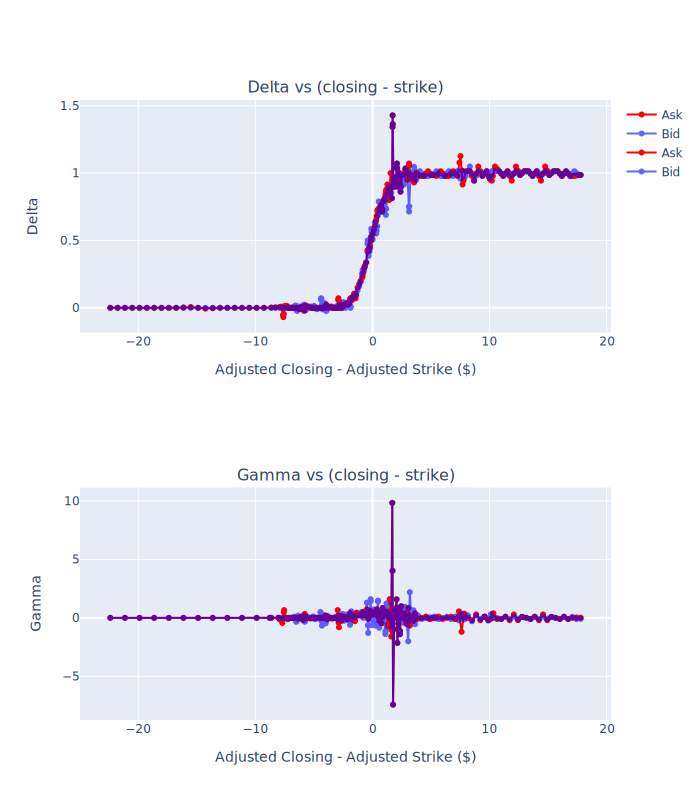

In [8]:
plot_date = datetime.date(2016, 1, 4)
plot_exp_date = datetime.date(2016, 1, 15)

viz_delta_df = delta_df[(delta_df["date"] == plot_date) &
                        (delta_df["expiration date"] == plot_exp_date)]

viz_gamma_df = gamma_df[(gamma_df["date"] == plot_date) &
                        (gamma_df["expiration date"] == plot_exp_date)]

if not viz_delta_df.shape[0]:
    raise Exception("Date and/or expiration date combo not valid!")

dg_fig = make_subplots(rows=2, cols=1,
                       subplot_titles=["Delta vs (closing - strike)", "Gamma vs (closing - strike)"])

for n in [viz_delta_df, viz_gamma_df]:
    if n.shape[0] == viz_delta_df.shape[0]:
        nrow = 1
    else:
        nrow = 2

    dg_fig.add_trace(go.Scatter(x=n["adj_close - adj_strike"],
                                y=n["ask"],
                                mode='lines+markers',
                                opacity=1,
                                marker_color="red",
                                name="Ask"),
                     row=nrow, col=1)

    dg_fig.add_trace(go.Scatter(x=n["adj_close - adj_strike"],
                                y=n["bid"],
                                mode='lines+markers',
                                opacity=0.6,
                                marker_color="blue",
                                name="Bid"),
                     row=nrow, col=1)

dg_fig.update_xaxes(title_text="Adjusted Closing - Adjusted Strike ($)")
dg_fig.update_yaxes(title_text="Delta", row=1)
dg_fig.update_yaxes(title_text="Gamma", row=2)
dg_fig.show("svg", width=700, height=800)

**Export data**

In [9]:
Path(default_save_path).mkdir(exist_ok=True)

delta_df.to_csv(path_or_buf=f"{default_save_path}{stock_of_interest}_calls_delta.csv", index=False)
gamma_df.to_csv(path_or_buf=f"{default_save_path}{stock_of_interest}_calls_gamma.csv", index=False)
